# Programming Assignment 5
## SVM and Random Forest

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CLASSIFIERS
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# METRICS
from sklearn import metrics as me

# UTILS
import time
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler


# Task 1 - SVM (Classification)

In [2]:
data = np.genfromtxt('../data/californiabin.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (3000, 9)


array([[   4.1685    ,   20.        ,    6.70063694,    1.17834395,
         745.        ,    2.37261146,   38.8       , -121.15      ,
           1.        ],
       [   2.8194    ,   24.        ,    4.7625    ,    1.02083333,
         608.        ,    2.53333333,   36.75      , -119.85      ,
           0.        ],
       [   2.425     ,   46.        ,    4.92771084,    1.01807229,
         772.        ,    2.3253012 ,   36.33      , -119.31      ,
           0.        ]])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=224852
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 2100 (70.0%)
X_test:  900 (30.0%)


In [4]:
# Scalling data
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
param_grid = {
    'C': [2**n for n in np.arange(-5, 16, 2, dtype=float)], 
    'gamma': [2**n for n in np.arange(-15, 4, 2, dtype=float)],
    'kernel': ['rbf']
}

svm = SVC()

cross_validation = KFold(n_splits=10, shuffle=True, random_state=87312)
grid_search = GridSearchCV(
    estimator=svm, 
    param_grid=param_grid, 
    cv=cross_validation
)

start = time.time()

grid_search.fit(X_train_scaled, y_train)

end = time.time()
print('The grid search process took', round(end-start, 4), 'seconds to finish.')

The grid search process took 382.5002  seconds to finish.


In [13]:
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'C': 32768.0, 'gamma': 0.5, 'kernel': 'rbf'}


In [14]:
svm = SVC(probability=True, **grid_search.best_params_)
svm.fit(X_train_scaled, y_train.ravel())


SVC(C=32768.0, gamma=0.5, probability=True)

In [15]:
y_train_pred_proba = svm.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = svm.predict_proba(X_test_scaled)[:, 1]

In [16]:
def get_metrics(y_true, y_pred_proba, threshold=0.5, dataset_name=''):

    y_pred_label = np.where(y_pred_proba>threshold, 1, 0)

    roc_curve = me.roc_curve(y_true, y_pred_proba)
    pr_curve = me.precision_recall_curve(y_true, y_pred_proba)

    metrics_dict = {
        'Acurácia': me.accuracy_score(y_true, y_pred_label),
        'Revocação': me.recall_score(y_true, y_pred_label),
        'Precisão': me.precision_score(y_true, y_pred_label),
        'F1-Score': me.f1_score(y_true, y_pred_label),
        'ROC AUC': me.auc(roc_curve[0], roc_curve[1]),
        'PR AUC': me.auc(pr_curve[1], pr_curve[0])
    }

    return pd.DataFrame([metrics_dict], index=[dataset_name])


In [18]:
def plot_curves(y_train, y_test, y_train_pred_proba, y_test_pred_proba, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(18,6))
    plt.suptitle(title, fontsize=20, fontweight='bold')

    # ROC CURVE
    roc_curve_train = me.roc_curve(y_train, y_train_pred_proba)
    roc_curve_test = me.roc_curve(y_test, y_test_pred_proba)

    axes[0].plot(
        roc_curve_train[0], roc_curve_train[1], 
        label=f'Train (AUC={me.auc(roc_curve_train[0], roc_curve_train[1]):.6f})'
    )
    axes[0].plot(
        roc_curve_test[0], roc_curve_test[1], 
        label=f'Test (AUC={me.auc(roc_curve_test[0], roc_curve_test[1]):.6f})'
    )
    axes[0].set_title('ROC CURVE')
    axes[0].legend()

    # PR CURVE
    pr_curve_train = me.precision_recall_curve(y_train, y_train_pred_proba)
    pr_curve_test = me.precision_recall_curve(y_test, y_test_pred_proba)

    axes[1].plot(
        pr_curve_train[1], pr_curve_train[0], 
        label=f'Train (AUC={me.auc(pr_curve_train[1], pr_curve_train[0]):.6f})'
    )
    axes[1].plot(
        pr_curve_test[1], pr_curve_test[0], 
        label=f'Test (AUC={me.auc(pr_curve_test[1], pr_curve_test[0]):.6f})'
    )
    axes[1].set_title('PR CURVE')
    axes[1].legend()


In [19]:
def make_confusion_matrix(
    cf,
    group_names=None,
    figsize=(8, 6),
    title=None,
    ax=None
):

    group_names = ['Verdadeiro Negativo', 'Falso Positivo', 'Falso Negativo', 'Verdadeiro Positivo']

    group_labels = ["{}\n\n".format(value) for value in group_names]
    group_counts = ["{0:0.0f}\n\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(
        group_labels, group_counts, group_percentages
    )]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.4f}\nPrecision={:0.4f}\nRecall={:0.4f}\nF1 Score={:0.4f}".format(
        accuracy, precision, recall, f1_score
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(
        cf, 
        annot=box_labels,
        annot_kws={"size": 12},
        fmt="",
        cmap='Blues',
        cbar=True,
        ax=ax
    )

    ax.set_ylabel('Real', size=12)
    ax.set_xlabel('Predição' + stats_text, size=12)

    ax.set_title(title)
    

def plot_confusion_matrix(
    y_train, 
    y_test, 
    y_train_pred_proba, 
    y_test_pred_proba, 
    threshold=0.5,
    title=''
):
    y_train_pred_label = np.where(y_train_pred_proba>threshold, 1, 0)
    y_test_pred_label = np.where(y_test_pred_proba>threshold, 1, 0)

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(title, fontsize=20, fontweight='bold')


    cf_matrix = me.confusion_matrix(y_train, y_train_pred_label)
    make_confusion_matrix(cf_matrix, title='Treino', ax=axes[0])

    cf_matrix = me.confusion_matrix(y_test, y_test_pred_label)
    make_confusion_matrix(cf_matrix, title='Teste', ax=axes[1])

,Acurácia,Revocação,Precisão,F1-Score,ROC AUC,PR AUC
Treino,0.893333,0.889529,0.894686,0.892100,0.961834,0.961607
Teste,0.882222,0.875817,0.891353,0.883516,0.937494,0.928990


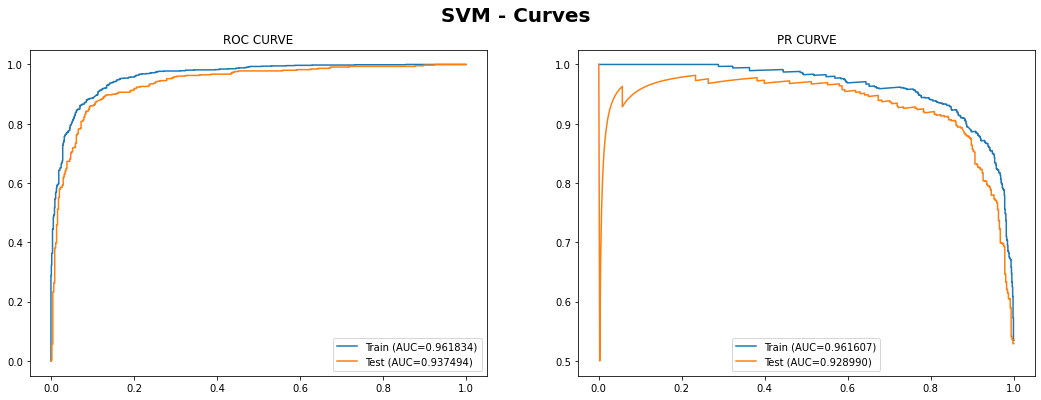

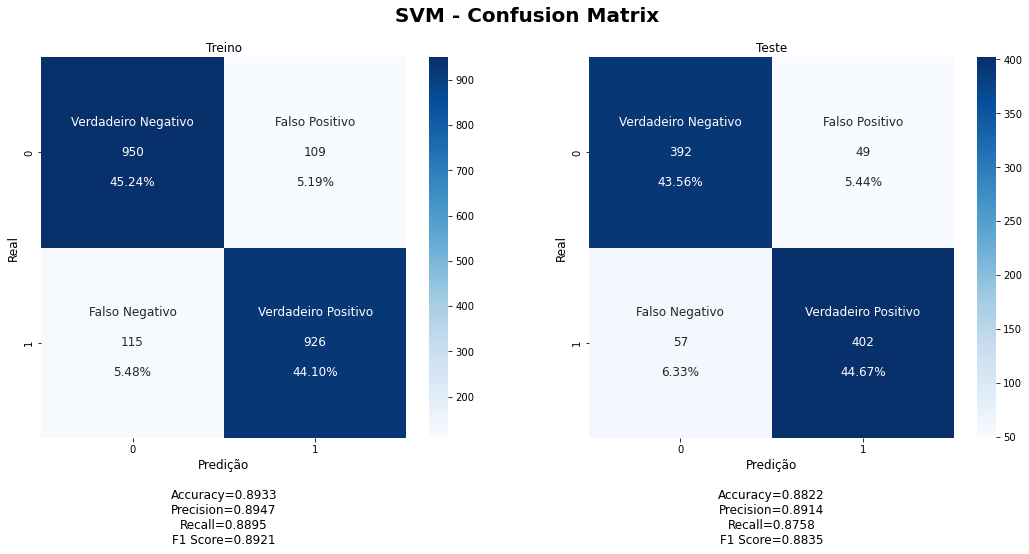

In [20]:
df_svm_metrics = pd.concat([
    get_metrics(y_train, y_train_pred_proba, dataset_name='Treino'),
    get_metrics(y_test, y_test_pred_proba, dataset_name='Teste')
])


display(df_svm_metrics)
plot_curves(
    y_train, y_test, y_train_pred_proba, 
    y_test_pred_proba, title='SVM - Curves'
)
plot_confusion_matrix(
    y_train, y_test, y_train_pred_proba, 
    y_test_pred_proba, title='SVM - Confusion Matrix'
)

# Task 2 - Random Forest (Classification)

In [21]:
data = np.genfromtxt('../data/californiabin.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]

Shape: (3000, 9)


array([[   4.1685    ,   20.        ,    6.70063694,    1.17834395,
         745.        ,    2.37261146,   38.8       , -121.15      ,
           1.        ],
       [   2.8194    ,   24.        ,    4.7625    ,    1.02083333,
         608.        ,    2.53333333,   36.75      , -119.85      ,
           0.        ],
       [   2.425     ,   46.        ,    4.92771084,    1.01807229,
         772.        ,    2.3253012 ,   36.33      , -119.31      ,
           0.        ]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=224852
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 2100 (70.0%)
X_test:  900 (30.0%)


In [27]:
param_grid = {
    'n_estimators': np.arange(10, 201, 10), 
    'max_depth': [None] + list(np.arange(2, 9, 2)),
}

random_forest = RandomForestClassifier(random_state=654821)

cross_validation = KFold(n_splits=10, shuffle=True, random_state=87312)
grid_search = GridSearchCV(
    estimator=random_forest, 
    param_grid=param_grid, 
    cv=cross_validation
)

start = time.time()

grid_search.fit(X_train, y_train)

end = time.time()
print('The grid search process took', round(end-start, 4), 'seconds to finish.')

The grid search process took 284.5037 seconds to finish.


In [28]:
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 20}


In [67]:
random_forest = RandomForestClassifier(**grid_search.best_params_, random_state=654851)
random_forest.fit(X_train, y_train.ravel())

RandomForestClassifier(n_estimators=20, random_state=654851)

In [68]:
y_train_pred_proba = random_forest.predict_proba(X_train)[:, 1]
y_test_pred_proba = random_forest.predict_proba(X_test)[:, 1]

Even getting almost 100% of accuracy in the training set, Random Forest performed 
as well as the SVM in the test set, being better in measurements of area under 
curve, which indicate that Random Forest apparently has most promising thresholds.

,Acurácia,Revocação,Precisão,F1-Score,ROC AUC,PR AUC
Treino,0.998571,0.997118,1.000000,0.998557,0.999995,0.999995
Teste,0.883333,0.858388,0.907834,0.882419,0.953742,0.959066


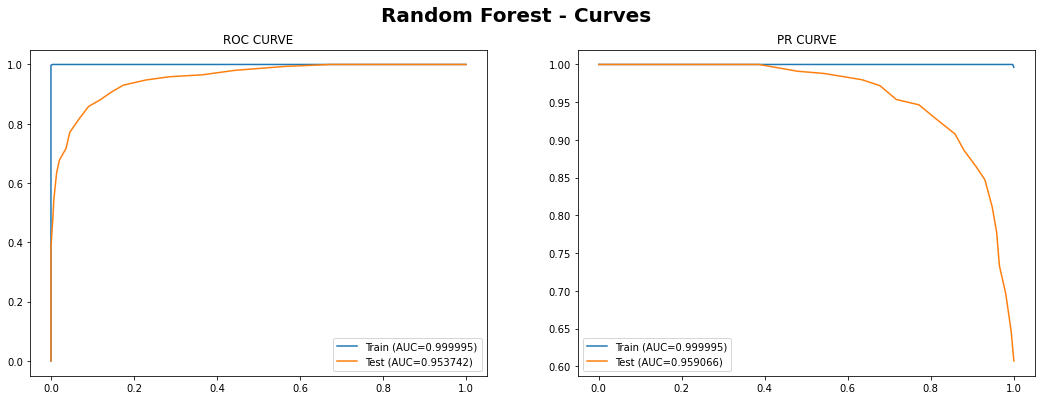

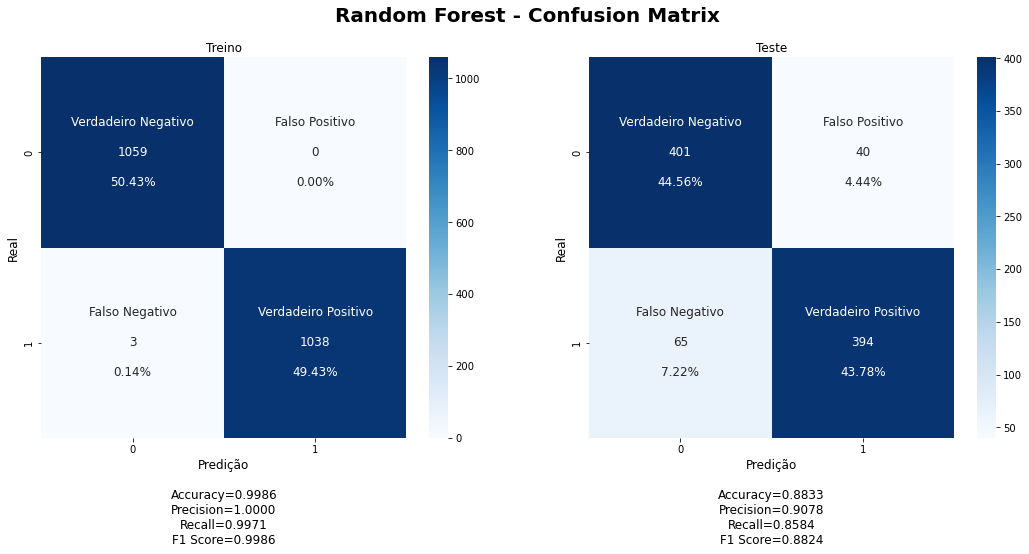

In [69]:
df_rf_metrics = pd.concat([
    get_metrics(y_train, y_train_pred_proba, dataset_name='Treino'),
    get_metrics(y_test, y_test_pred_proba, dataset_name='Teste')
])

display(df_rf_metrics)
plot_curves(y_train, y_test, y_train_pred_proba, y_test_pred_proba, title='Random Forest - Curves')
plot_confusion_matrix(y_train, y_test, y_train_pred_proba, y_test_pred_proba, title='Random Forest - Confusion Matrix')
